In [30]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
sns.set_context("talk")


def get_hits_summary(hits_path, label = "label_placeholder", drop = None):
    # Check how many structures I retrieve
    colnames  = "query,target,fident,alnlen,gapopen,qseq,tseq,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,qcut,tcut,qcut_len,tcut_len,qseq_len,tseq_len,family".split(",")
    hits_summary = pd.DataFrame()
    for file in glob.glob(hits_path):
        family = os.path.splitext(os.path.basename(file))[0]
        
        if os.path.getsize(file) > 0: 
            df = pd.read_csv(file, sep= "\t", header = None)
            if drop: 
                df.drop(df.columns[14:19], axis=1, inplace=True)
            df["family"] = family.replace("_filtered_hits", "")
            hits_summary = pd.concat([hits_summary, df])
    hits_summary = hits_summary.set_axis(colnames, axis='columns')
    hits_summary = hits_summary[["family", "query"]].drop_duplicates().groupby("family").count().reset_index().set_axis(["family", "found"], axis='columns')
    hits_summary["label"] = label
    return(hits_summary)

# Collect dataset infos

In [31]:
outdir = "../outdir/REFERENCES"
families = pd.read_csv(os.path.join(outdir, "SUMMARIES/input_sequences/stats_summary_report.csv"))
families.rename(columns = {"id":"family"}, inplace=True)
families.family = families.family.str.replace('.', "-", regex = False)

In [32]:
families

,family,perc_sim,seqlength_mean,seqlength_median,seqlength_max,n_sequences
0,KAS-ref,34.60,344.666667,334.0,388,6
1,aadh-ref,40.93,415.125000,416.0,501,8
2,subt-ref,43.04,294.363636,279.0,369,11
3,scorptoxin-ref,48.57,64.750000,64.5,67,8
4,bowman-ref,66.60,50.000000,61.0,71,5
...,...,...,...,...,...,...
89,p450-ref,26.55,408.000000,402.5,456,12
90,toxin-ref,44.45,63.500000,61.0,74,20
91,tgfb-ref,45.64,97.625000,105.0,112,8
92,sodfe-ref,46.21,198.500000,199.5,205,8


In [34]:
hits_1 = get_hits_summary(os.path.join(outdir, "SEARCH/filter/0.9_1/*.m8"),   label = "1")
hits_1_summary = hits_1.merge(families, on = "family", how = "outer").fillna(0)

In [35]:
hits_1_summary

,family,found,label,perc_sim,seqlength_mean,seqlength_median,seqlength_max,n_sequences
0,Acetyltransf-ref,5.0,1,29.07,161.500000,163.0,181,6
1,Ald_Xan_dh_2-ref,4.0,1,34.47,763.500000,777.0,804,6
2,ChtBD-ref,5.0,1,58.90,42.600000,43.0,43,5
3,DEATH-ref,6.0,1,26.90,107.142857,102.0,150,7
4,DMRL_synthase-ref,4.0,1,34.20,158.000000,155.0,168,5
...,...,...,...,...,...,...,...,...
89,trfl-ref,6.0,1,62.33,526.285714,682.0,689,7
90,uce-ref,11.0,1,35.37,149.384615,149.0,164,13
91,zf-CCHH-ref,8.0,1,35.90,29.066667,29.0,34,15
92,rhv-ref,0.0,0,37.07,780.833333,798.5,854,6


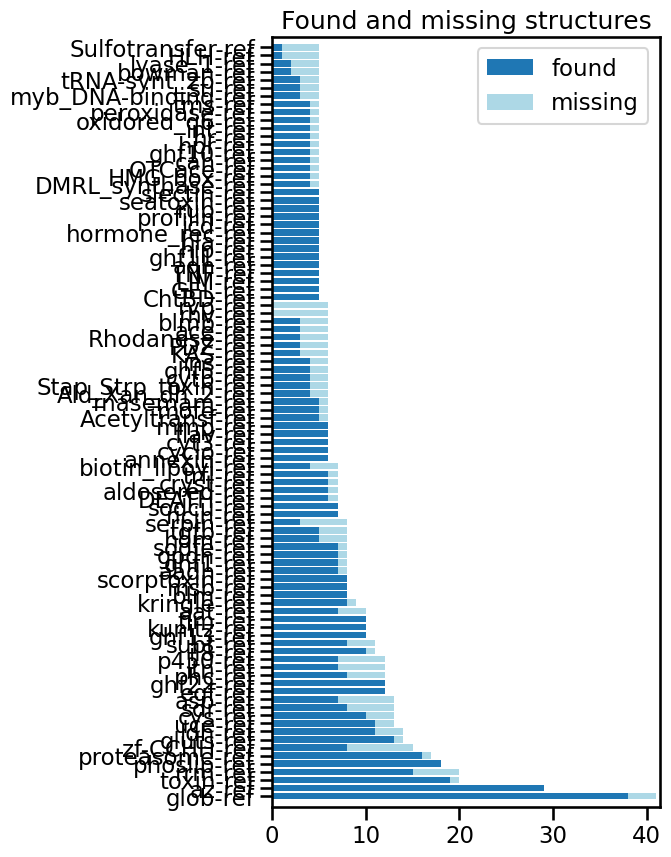

In [36]:
hits = hits_1_summary
hits["missing"] = hits.n_sequences- hits.found
hits = hits.sort_values(by=['n_sequences', "found"], ascending=False)
plt.figure(figsize=(5, 10))
plt.barh(hits.family, hits.found, label = "found")
plt.barh(hits.family, hits["missing"], left= hits.found, label = "missing", color = "lightblue")
plt.title("Found and missing structures")
plt.legend(loc = "upper right")
plt.margins(0.01)
plt.show()

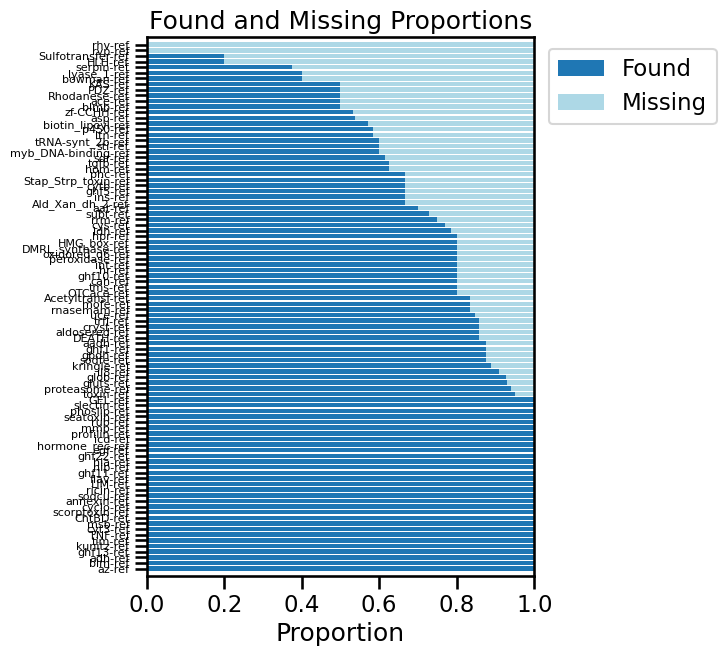

In [37]:
# Plot with proportions
# Calculate proportions
hits['found_proportion'] = hits['found'] / (hits['found'] + hits['missing'])
hits['missing_proportion'] = hits['missing'] / (hits['found'] + hits['missing'])

# Sort by the found_proportion in descending order
hits = hits.sort_values(by=['found_proportion'], ascending=False)

plt.figure(figsize=(5, 7))

# make labels smalle 
plt.rc('ytick', labelsize=8)
# Plot found proportions
plt.barh(hits.family, hits['found_proportion'], label="Found")

# Plot missing proportions next to found proportions
plt.barh(hits.family, hits['missing_proportion'], left=hits['found_proportion'], label="Missing", color="lightblue")

plt.title("Found and Missing Proportions" ) 
plt.xlabel("Proportion")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.margins(0.01)
plt.show()

In [41]:
hits_missing = hits[hits.missing > 0]
",".join(hits_missing.family.tolist())


'toxin-ref,proteasome-ref,gluts-ref,glob-ref,il8-ref,kringle-ref,sodfe-ref,gpdh-ref,ghf1-ref,aadh-ref,DEATH-ref,aldosered-ref,cryst-ref,trfl-ref,uce-ref,rnasemam-ref,mofe-ref,Acetyltransf-ref,OTCace-ref,tms-ref,cah-ref,ghf10-ref,hr-ref,int-ref,peroxidase-ref,oxidored_q6-ref,DMRL_synthase-ref,HMG_box-ref,hpr-ref,ldh-ref,cys-ref,rrm-ref,subt-ref,aat-ref,Ald_Xan_dh_2-ref,ins-ref,ghf5-ref,cytb-ref,Stap_Strp_toxin-ref,phc-ref,hom-ref,tgfb-ref,sdr-ref,myb_DNA-binding-ref,sti-ref,tRNA-synt_2b-ref,ltn-ref,p450-ref,biotin_lipoyl-ref,asp-ref,zf-CCHH-ref,blmb-ref,ace-ref,Rhodanese-ref,PDZ-ref,KAS-ref,bowman-ref,lyase_1-ref,serpin-ref,HLH-ref,Sulfotransfer-ref,rvp-ref,rhv-ref'

In [40]:
hits_found = hits[hits.missing == 0]
len(hits_found.family.tolist())


31